Shape of HSI data: (145, 145, 200)
Shape of ground truth: (145, 145)
hi


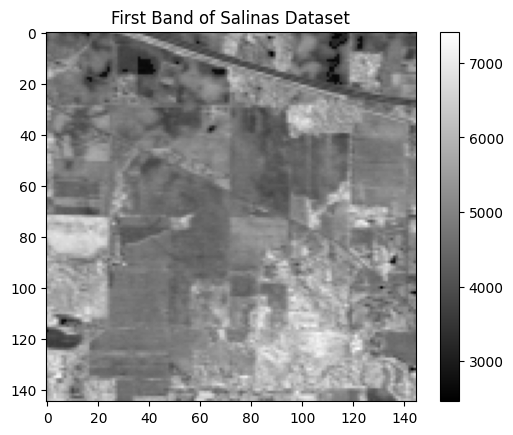

In [23]:
import scipy.io as sio
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the hyperspectral data and ground-truth labels
data = sio.loadmat('Indian_pines_corrected.mat')  # Replace with your file path
ground_truth_data = sio.loadmat('Indian_pines_gt.mat')  # Replace with your file path

# Extract hyperspectral image and ground truth
hsi_data = data['indian_pines_corrected']  # HSI data, shape (145, 145, 200)
ground_truth = ground_truth_data['indian_pines_gt']  # Ground truth labels, shape (145, 145)

print("Shape of HSI data:", hsi_data.shape)
print("Shape of ground truth:", ground_truth.shape)

# Normalize the hyperspectral data to the range [0, 1]
hsi_data_normalized = hsi_data.astype(np.float32)
hsi_data_normalized = (hsi_data_normalized - np.min(hsi_data_normalized)) / (np.max(hsi_data_normalized) - np.min(hsi_data_normalized))

# Flatten the HSI data and ground truth for pixel-based processing
num_pixels = hsi_data_normalized.shape[0] * hsi_data_normalized.shape[1]
num_bands = hsi_data_normalized.shape[2]
data_reshaped = hsi_data_normalized.reshape(num_pixels, 1, num_bands)
labels = ground_truth.flatten()

# Filter out background pixels (typically labeled as 0)
valid_indices = labels > 0
data_reshaped = data_reshaped[valid_indices]
labels = labels[valid_indices] - 1  # Shift labels to start from 0

# Convert data and labels to PyTorch tensors
data_tensor = torch.tensor(data_reshaped, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Create dataset and dataloader
batch_size = 64
dataset = TensorDataset(data_tensor, labels_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("hi")
# Display the first band as an example
import matplotlib.pyplot as plt

plt.imshow(hsi_data[:, :, 45], cmap='gray')
plt.title('First Band of Salinas Dataset')
plt.colorbar()
plt.show()

In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Attention Module
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv = nn.Conv1d(in_channels, 1, kernel_size=1)
        
    def forward(self, x):
        attention_weights = self.conv(x)
        attention_weights = F.relu(attention_weights)
        attention_weights = F.softmax(attention_weights, dim=2)
        return attention_weights * x

# Define the CNN with Attention-based Band Selection
class AttentionBasedCNN(nn.Module):
    def __init__(self, num_bands, num_classes):
        super(AttentionBasedCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 96, kernel_size=5, padding=2)
        self.att1 = AttentionModule(96)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(96, 54, kernel_size=5, padding=2)
        self.att2 = AttentionModule(54)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(54, 36, kernel_size=5, padding=2)
        self.att3 = AttentionModule(36)
        self.pool3 = nn.MaxPool1d(2)
        
        self.fc1 = nn.Linear((num_bands // 8) * 36, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.att1(self.conv1(x))))
        x = self.pool2(F.relu(self.att2(self.conv2(x))))
        x = self.pool3(F.relu(self.att3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [5]:
# Training parameters
num_classes = len(np.unique(labels))  # Calculate the number of classes from labels
learning_rate = 0.001
num_epochs = 30

# Initialize model, optimizer, and loss function
model = AttentionBasedCNN(num_bands=num_bands, num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for data, target in train_loader:
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/30], Loss: 2.4864
Epoch [2/30], Loss: 2.3295
Epoch [3/30], Loss: 2.2352
Epoch [4/30], Loss: 1.5198
Epoch [5/30], Loss: 1.3502
Epoch [6/30], Loss: 1.2735
Epoch [7/30], Loss: 1.2253
Epoch [8/30], Loss: 1.1845
Epoch [9/30], Loss: 1.1510
Epoch [10/30], Loss: 1.1242
Epoch [11/30], Loss: 1.1036
Epoch [12/30], Loss: 1.0883
Epoch [13/30], Loss: 1.0759
Epoch [14/30], Loss: 1.0614
Epoch [15/30], Loss: 1.0593
Epoch [16/30], Loss: 1.0502
Epoch [17/30], Loss: 1.0353
Epoch [18/30], Loss: 1.0283
Epoch [19/30], Loss: 1.0191
Epoch [20/30], Loss: 1.0108
Epoch [21/30], Loss: 1.0079
Epoch [22/30], Loss: 0.9931
Epoch [23/30], Loss: 0.9943
Epoch [24/30], Loss: 0.9903
Epoch [25/30], Loss: 0.9842
Epoch [26/30], Loss: 0.9776
Epoch [27/30], Loss: 0.9788
Epoch [28/30], Loss: 0.9679
Epoch [29/30], Loss: 0.9650
Epoch [30/30], Loss: 0.9568


In [6]:
with torch.no_grad():
    attention_scores = []
    for data, _ in train_loader:
        # Pass through attention layers to get attention scores
        a1 = model.att1(model.conv1(data))
        a2 = model.att2(model.conv2(a1))
        a3 = model.att3(model.conv3(a2))
        
        # Aggregate the attention scores from the last layer
        attention_scores.append(a3.cpu().numpy())
    
    # Average attention scores across all batches
    attention_scores = np.concatenate(attention_scores, axis=0)
    attention_scores = attention_scores.mean(axis=0)


In [8]:
from sklearn.covariance import EllipticEnvelope

def select_important_bands(attention_scores, contamination_rate=0.01):
    model = EllipticEnvelope(contamination=contamination_rate)
    selected_bands = model.fit_predict(attention_scores.reshape(-1, 1))
    important_band_indices = [i for i, v in enumerate(selected_bands) if v == -1]
    return important_band_indices

# Select important bands
important_bands = select_important_bands(attention_scores)
print("Important Bands Selected:", important_bands)
print(len(important_bands))

Important Bands Selected: [241, 440, 441, 442, 640, 641, 642, 643, 1040, 1041, 1042, 1240, 1241, 1242, 1243, 1440, 1441, 1442, 1443, 1841, 1842, 2040, 2041, 2042, 2043, 2241, 2242, 2641, 2642, 2840, 2841, 2842, 2843, 3040, 3041, 3042, 3043, 3440, 3441, 3442, 3443, 3444, 3641, 3642, 3841, 4040, 4041, 4042, 4640, 4641, 4642, 5640, 5641, 5642, 5643, 5841, 6041, 6042, 6240, 6241, 6242, 6243, 6640, 6641, 6642, 6840, 6841, 6842, 7040, 7041, 7042, 7043]
72


In [20]:
from sklearn.covariance import EllipticEnvelope

def select_important_bands(attention_scores, contamination_rate=0.1):
    """
    Selects important bands using EllipticEnvelope with an adjusted support_fraction.
    """
    model = EllipticEnvelope(contamination=contamination_rate, support_fraction=0.9)  # Adjusted support fraction
    selected_bands = model.fit_predict(attention_scores.reshape(-1, 1))
    important_band_indices = [i for i, v in enumerate(selected_bands) if v == -1]
    return important_band_indices

# Call the function on mean attention scores
important_bands = select_important_bands(mean_attention_scores)
print("Important Bands Selected:", important_bands)


Important Bands Selected: [6, 7, 8, 9, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


In [11]:
from sklearn.ensemble import IsolationForest

def select_important_bands_isolation_forest(attention_scores, contamination_rate=0.01):
    """
    Selects important bands using IsolationForest for outlier detection.
    """
    model = IsolationForest(contamination=contamination_rate, random_state=42)
    selected_bands = model.fit_predict(attention_scores.reshape(-1, 1))
    important_band_indices = [i for i, v in enumerate(selected_bands) if v == -1]
    return important_band_indices

# Call the function on mean attention scores
important_bands = select_important_bands_isolation_forest(mean_attention_scores)
print("Important Bands Selected:", important_bands)


Important Bands Selected: [41, 42]
